# Preparation of Dataset (development notebook)

## Import section

In [1]:
import numpy as np
import pandas as pd

from etnn.data.prepare_ferris_wheel import prepare_1_ferris, generate_ferris_dataset, add_valid_permutations, \
    sample_new_permutations
from etnn.data.ferris_score_helpers import build_wheel_happyness
from etnn.data.ferris_wheel import load_pure_ferris_wheel_dataset, load_modified_ferris_wheel_dataset
import torch
from torch.utils.data import random_split, DataLoader
from tqdm import tqdm

from etnn.tools.loader import create_sampler

In [2]:
DATASET_PATH = "../datasets"

## Person dataset

In [3]:
df_health = prepare_1_ferris(
    dataset_path="../datasets",
    df_name_output="health_dataset_preprocessed-1.csv",
    df_name_input="Sleep_health_and_lifestyle_dataset.csv",
    try_pregen=True
)

In [4]:
df_health.head()

,id,age,occupation,sleep_duration,sleep_quality,physical_activity,stress_level,bmi,heart_rate,daily_steps,sleep_disorder,blood_pressure1,blood_pressure2,gender_male,gender_female,gender_other
0,1,27,1,6.1,6,42,6,2,77,4200,0,126,83,True,False,False
1,2,28,2,6.2,6,60,8,0,75,10000,0,125,80,True,False,False
2,3,28,2,6.2,6,60,8,0,75,10000,0,125,80,True,False,False
3,4,28,3,5.9,4,30,8,3,85,3000,1,140,90,True,False,False
4,5,28,3,5.9,4,30,8,3,85,3000,1,140,90,True,False,False


## Gondola dataset (indexing)

In [5]:
# take group of ids from persons and state how the label for this group shall be calculated

In [6]:
# define ferris wheel
num_gondolas = 10
num_part_pg = 5

In [7]:
# generate sample element
random_order = np.arange(len(df_health)) + 1
np.random.shuffle(random_order)

In [8]:
example = [
    random_order[i*num_part_pg:(i+1)*num_part_pg]
    for i in range(num_gondolas)
]

In [9]:
example

[array([165, 241,  47, 117, 154]),
 array([323,  89, 138, 191,  13]),
 array([ 11, 133, 320,  31, 139]),
 array([192,  83,  12, 253, 340]),
 array([246, 247,  94, 289,  49]),
 array([147,  70, 233, 334, 118]),
 array([182, 364, 346, 137, 272]),
 array([339,  72,  14, 248, 157]),
 array([ 79,  36, 365, 181, 151]),
 array([ 19, 173, 111, 122,  86])]

In [10]:
random_order[:num_gondolas*num_part_pg].reshape(num_gondolas, num_part_pg)

array([[165, 241,  47, 117, 154],
       [323,  89, 138, 191,  13],
       [ 11, 133, 320,  31, 139],
       [192,  83,  12, 253, 340],
       [246, 247,  94, 289,  49],
       [147,  70, 233, 334, 118],
       [182, 364, 346, 137, 272],
       [339,  72,  14, 248, 157],
       [ 79,  36, 365, 181, 151],
       [ 19, 173, 111, 122,  86]])

Rules:
- People being happy with other people in same gondola
    + Age composition too seperated is bad
    + shift in gender is bad if too much, 50-50 is good or all one gender
    + same with age composition
    + sleep derived(multiplier with quality) persons get a subtraction and 'good sleepers' get bonus (sleep disorder counts as stronger subtraction)
    + higher heart rate and pressure = joy or fear
    + composition of persons in regards to bmi : extreme values make others (no exception for group all those as to many underweight or overweight persons may be awquard as well)
- People being happy with neighboring gondolas composition
    + same age gets bonus, none gets penalty as potentially group is separated
    + gap between happyness index between self and neighbors causes it to produce a mean of only the neighbors

In [11]:
build_wheel_happyness(df_health, example)

68.00913333333332

In [12]:
build_wheel_happyness(df_health, random_order[:num_gondolas * num_part_pg].reshape(num_gondolas, num_part_pg))

68.00913333333332

In [13]:
# define dataset size
num_to_generate = 10_000
# define ferris wheel
num_gondolas = 10
num_part_pg = 5

In [14]:
df_index, df_health = generate_ferris_dataset(
    num_gondolas=num_gondolas,
    num_part_pg=num_part_pg,
    num_to_generate=num_to_generate,
    dataset_path="../datasets",
    df_intermediate_output_name="health_dataset_preprocessed-1.csv",
    df_name_input="Sleep_health_and_lifestyle_dataset.csv",
    try_pregen=True
)

In [15]:
df_index.head()

,g-0_p-0,g-0_p-1,g-0_p-2,g-0_p-3,g-0_p-4,g-1_p-0,g-1_p-1,g-1_p-2,g-1_p-3,g-1_p-4,...,g-8_p-1,g-8_p-2,g-8_p-3,g-8_p-4,g-9_p-0,g-9_p-1,g-9_p-2,g-9_p-3,g-9_p-4,label
0,264,191,98,235,35,356,253,9,147,311,...,315,265,92,23,287,17,234,223,117,68.011480
1,338,176,95,11,161,248,364,53,64,71,...,181,365,96,187,165,38,114,98,56,55.463373
2,290,99,75,21,237,287,215,213,172,214,...,76,188,274,77,264,117,254,168,65,66.108493
3,15,277,93,106,290,354,60,226,75,318,...,243,288,74,131,344,86,266,218,83,58.642507
4,190,260,34,286,360,167,251,298,256,15,...,48,258,107,5,307,121,162,7,37,62.584213


In [16]:
df_health.head()

,id,age,occupation,sleep_duration,sleep_quality,physical_activity,stress_level,bmi,heart_rate,daily_steps,sleep_disorder,blood_pressure1,blood_pressure2,gender_male,gender_female,gender_other
0,1,27,1,6.1,6,42,6,2,77,4200,0,126,83,True,False,False
1,2,28,2,6.2,6,60,8,0,75,10000,0,125,80,True,False,False
2,3,28,2,6.2,6,60,8,0,75,10000,0,125,80,True,False,False
3,4,28,3,5.9,4,30,8,3,85,3000,1,140,90,True,False,False
4,5,28,3,5.9,4,30,8,3,85,3000,1,140,90,True,False,False


In [17]:
df_index.iloc[:, :-1]

,g-0_p-0,g-0_p-1,g-0_p-2,g-0_p-3,g-0_p-4,g-1_p-0,g-1_p-1,g-1_p-2,g-1_p-3,g-1_p-4,...,g-8_p-0,g-8_p-1,g-8_p-2,g-8_p-3,g-8_p-4,g-9_p-0,g-9_p-1,g-9_p-2,g-9_p-3,g-9_p-4
0,264,191,98,235,35,356,253,9,147,311,...,299,315,265,92,23,287,17,234,223,117
1,338,176,95,11,161,248,364,53,64,71,...,100,181,365,96,187,165,38,114,98,56
2,290,99,75,21,237,287,215,213,172,214,...,122,76,188,274,77,264,117,254,168,65
3,15,277,93,106,290,354,60,226,75,318,...,235,243,288,74,131,344,86,266,218,83
4,190,260,34,286,360,167,251,298,256,15,...,28,48,258,107,5,307,121,162,7,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,127,84,110,152,265,90,318,72,331,237,...,346,7,341,126,70,208,67,248,291,246
9996,286,97,191,288,32,268,41,347,272,169,...,194,178,269,310,79,370,108,189,340,24
9997,372,168,198,199,239,369,323,277,174,281,...,191,112,75,331,177,163,155,7,188,290
9998,154,310,224,59,87,207,97,78,290,241,...,12,338,254,183,145,22,95,247,158,231


## Total dataset creation

In [18]:
dataset, _ = load_pure_ferris_wheel_dataset(
    num_gondolas=num_gondolas,
    num_part_pg=num_part_pg,
    num_to_generate=num_to_generate,
    dataset_path="../datasets",
    df_intermediate_output_name="health_dataset_preprocessed-1.csv",
    df_name_input="Sleep_health_and_lifestyle_dataset.csv",
    try_pregen=True
)

In [19]:
dataset[0]

(tensor([[4.5000e+01, 1.1000e+01, 6.9000e+00, 7.0000e+00, 5.5000e+01, 5.0000e+00,
          2.0000e+00, 7.5000e+01, 5.5000e+03, 0.0000e+00, 1.2500e+02, 8.2000e+01,
          0.0000e+00, 1.0000e+00, 0.0000e+00],
         [4.3000e+01, 4.0000e+00, 6.7000e+00, 7.0000e+00, 4.5000e+01, 4.0000e+00,
          2.0000e+00, 6.5000e+01, 6.0000e+03, 2.0000e+00, 1.3500e+02, 9.0000e+01,
          0.0000e+00, 1.0000e+00, 0.0000e+00],
         [3.6000e+01, 7.0000e+00, 7.1000e+00, 8.0000e+00, 6.0000e+01, 4.0000e+00,
          0.0000e+00, 6.8000e+01, 7.0000e+03, 0.0000e+00, 1.1500e+02, 7.5000e+01,
          0.0000e+00, 1.0000e+00, 0.0000e+00],
         [4.4000e+01, 4.0000e+00, 6.6000e+00, 7.0000e+00, 4.5000e+01, 4.0000e+00,
          2.0000e+00, 6.5000e+01, 6.0000e+03, 2.0000e+00, 1.3500e+02, 9.0000e+01,
          0.0000e+00, 1.0000e+00, 0.0000e+00],
         [3.1000e+01, 2.0000e+00, 7.7000e+00, 7.0000e+00, 7.5000e+01, 6.0000e+00,
          0.0000e+00, 7.0000e+01, 8.0000e+03, 0.0000e+00, 1.2000e+02, 8.00

## DataLoaders

In [20]:
generator = torch.Generator().manual_seed(420)
train_ds, val_ds, test_ds = random_split(dataset, [0.7, 0.1, 0.2], generator=generator)

In [21]:
train_ds

In [22]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

In [23]:
for x, y in train_loader:
    print(f"x-shape:{x.shape}, y-shape:{y.shape}")
    break

x-shape:torch.Size([32, 50, 15]), y-shape:torch.Size([32])


## Specialize pure datasets

In [24]:
df_added_valid = add_valid_permutations(
    num_to_generate,
    df_index,
    num_gondolas
)

100%|██████████| 10000/10000 [00:00<00:00, 97085.88it/s]


In [25]:
df_added_valid

,g-0_p-0,g-0_p-1,g-0_p-2,g-0_p-3,g-0_p-4,g-1_p-0,g-1_p-1,g-1_p-2,g-1_p-3,g-1_p-4,...,g-8_p-1,g-8_p-2,g-8_p-3,g-8_p-4,g-9_p-0,g-9_p-1,g-9_p-2,g-9_p-3,g-9_p-4,label
0,264,191,98,235,35,356,253,9,147,311,...,315,265,92,23,287,17,234,223,117,68.011480
1,338,176,95,11,161,248,364,53,64,71,...,181,365,96,187,165,38,114,98,56,55.463373
2,290,99,75,21,237,287,215,213,172,214,...,76,188,274,77,264,117,254,168,65,66.108493
3,15,277,93,106,290,354,60,226,75,318,...,243,288,74,131,344,86,266,218,83,58.642507
4,190,260,34,286,360,167,251,298,256,15,...,48,258,107,5,307,121,162,7,37,62.584213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,14,204,272,195,136,217,178,137,46,197,...,263,94,345,248,227,6,102,127,301,59.765280
19996,278,282,328,303,251,265,25,243,199,365,...,342,188,40,77,39,358,34,290,335,71.027800
19997,169,160,69,298,314,234,346,350,246,338,...,173,73,277,286,70,17,180,118,137,71.582987
19998,26,358,181,46,355,83,54,366,125,155,...,277,174,80,106,260,342,194,287,371,57.986000


In [26]:
dataset, _ = load_modified_ferris_wheel_dataset(
    num_gondolas=num_gondolas,
    num_part_pg=num_part_pg,
    num_to_generate=num_to_generate,
    num_valid_to_add=num_to_generate,
    dataset_path="../datasets",
    df_intermediate_output_name="health_dataset_preprocessed-1.csv",
    df_name_input="Sleep_health_and_lifestyle_dataset.csv",
    try_pregen=True
)

100%|██████████| 1000/1000 [00:00<00:00, 76931.47it/s]


In [27]:
dataset[0]

(tensor([[4.5000e+01, 1.1000e+01, 6.9000e+00, 7.0000e+00, 5.5000e+01, 5.0000e+00,
          2.0000e+00, 7.5000e+01, 5.5000e+03, 0.0000e+00, 1.2500e+02, 8.2000e+01,
          0.0000e+00, 1.0000e+00, 0.0000e+00],
         [4.3000e+01, 4.0000e+00, 6.7000e+00, 7.0000e+00, 4.5000e+01, 4.0000e+00,
          2.0000e+00, 6.5000e+01, 6.0000e+03, 2.0000e+00, 1.3500e+02, 9.0000e+01,
          0.0000e+00, 1.0000e+00, 0.0000e+00],
         [3.6000e+01, 7.0000e+00, 7.1000e+00, 8.0000e+00, 6.0000e+01, 4.0000e+00,
          0.0000e+00, 6.8000e+01, 7.0000e+03, 0.0000e+00, 1.1500e+02, 7.5000e+01,
          0.0000e+00, 1.0000e+00, 0.0000e+00],
         [4.4000e+01, 4.0000e+00, 6.6000e+00, 7.0000e+00, 4.5000e+01, 4.0000e+00,
          2.0000e+00, 6.5000e+01, 6.0000e+03, 2.0000e+00, 1.3500e+02, 9.0000e+01,
          0.0000e+00, 1.0000e+00, 0.0000e+00],
         [3.1000e+01, 2.0000e+00, 7.7000e+00, 7.0000e+00, 7.5000e+01, 6.0000e+00,
          0.0000e+00, 7.0000e+01, 8.0000e+03, 0.0000e+00, 1.2000e+02, 8.00

## Change regression task to classification

In [28]:
temp = df_index.label/(10*num_gondolas)*10

In [29]:
temp.round()

0       7.0
1       6.0
2       7.0
3       6.0
4       6.0
       ... 
9995    6.0
9996    6.0
9997    7.0
9998    7.0
9999    5.0
Name: label, Length: 10000, dtype: float64

## Problem: dataset too centered around a specific value

In [30]:
df_index.label.describe()

count    10000.000000
mean        63.529537
std          5.500780
min         48.837187
25%         59.621903
50%         63.253673
75%         66.986460
max         90.799333
Name: label, dtype: float64

<Axes: >

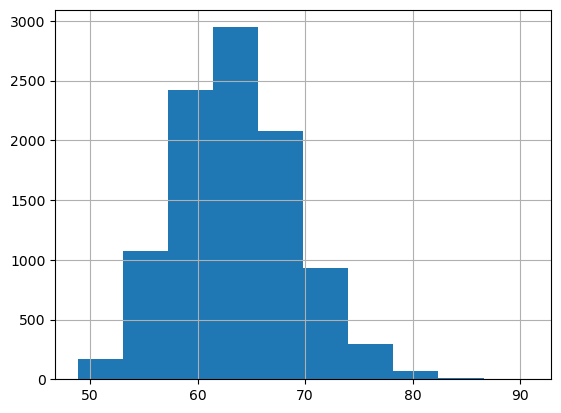

In [31]:
df_index.label.hist()

In [32]:
df_downsample = df_index.copy(deep=True)
df_downsample

,g-0_p-0,g-0_p-1,g-0_p-2,g-0_p-3,g-0_p-4,g-1_p-0,g-1_p-1,g-1_p-2,g-1_p-3,g-1_p-4,...,g-8_p-1,g-8_p-2,g-8_p-3,g-8_p-4,g-9_p-0,g-9_p-1,g-9_p-2,g-9_p-3,g-9_p-4,label
0,264,191,98,235,35,356,253,9,147,311,...,315,265,92,23,287,17,234,223,117,68.011480
1,338,176,95,11,161,248,364,53,64,71,...,181,365,96,187,165,38,114,98,56,55.463373
2,290,99,75,21,237,287,215,213,172,214,...,76,188,274,77,264,117,254,168,65,66.108493
3,15,277,93,106,290,354,60,226,75,318,...,243,288,74,131,344,86,266,218,83,58.642507
4,190,260,34,286,360,167,251,298,256,15,...,48,258,107,5,307,121,162,7,37,62.584213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,127,84,110,152,265,90,318,72,331,237,...,7,341,126,70,208,67,248,291,246,63.678893
9996,286,97,191,288,32,268,41,347,272,169,...,178,269,310,79,370,108,189,340,24,55.686920
9997,372,168,198,199,239,369,323,277,174,281,...,112,75,331,177,163,155,7,188,290,66.045467
9998,154,310,224,59,87,207,97,78,290,241,...,338,254,183,145,22,95,247,158,231,72.811613


In [33]:
df_downsample['label_cat'] = (df_downsample.label/5).round()

In [34]:
df_downsample

,g-0_p-0,g-0_p-1,g-0_p-2,g-0_p-3,g-0_p-4,g-1_p-0,g-1_p-1,g-1_p-2,g-1_p-3,g-1_p-4,...,g-8_p-2,g-8_p-3,g-8_p-4,g-9_p-0,g-9_p-1,g-9_p-2,g-9_p-3,g-9_p-4,label,label_cat
0,264,191,98,235,35,356,253,9,147,311,...,265,92,23,287,17,234,223,117,68.011480,14.0
1,338,176,95,11,161,248,364,53,64,71,...,365,96,187,165,38,114,98,56,55.463373,11.0
2,290,99,75,21,237,287,215,213,172,214,...,188,274,77,264,117,254,168,65,66.108493,13.0
3,15,277,93,106,290,354,60,226,75,318,...,288,74,131,344,86,266,218,83,58.642507,12.0
4,190,260,34,286,360,167,251,298,256,15,...,258,107,5,307,121,162,7,37,62.584213,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,127,84,110,152,265,90,318,72,331,237,...,341,126,70,208,67,248,291,246,63.678893,13.0
9996,286,97,191,288,32,268,41,347,272,169,...,269,310,79,370,108,189,340,24,55.686920,11.0
9997,372,168,198,199,239,369,323,277,174,281,...,75,331,177,163,155,7,188,290,66.045467,13.0
9998,154,310,224,59,87,207,97,78,290,241,...,254,183,145,22,95,247,158,231,72.811613,15.0


In [35]:
n_samples = df_downsample.groupby('label_cat').size().min()
n_samples

1

In [36]:
downsampled_df = df_downsample.groupby('label_cat').apply(lambda x: x.sample(min(len(x), 10)))
downsampled_df

g-0_p-0  g-0_p-1  g-0_p-2  g-0_p-3  g-0_p-4  g-1_p-0  g-1_p-1  \
label_cat                                                                       
10.0      441       160      217      281      247      172      374      194   
          4083      224      106      120      349      180      245      319   
          8442      265       99      215       95       43      362      289   
          3276       62        4      288      114       85      148      307   
          3295      154        2      207      332      351      122      245   
...                 ...      ...      ...      ...      ...      ...      ...   
17.0      5691      231       92        3      230       81      191      314   
          5103      200      247      181       49      260      342      156   
          1733       91      101      360      134       87      188      163   
          2424      106        4      199      269      110       98      129   
18.0      7641      314      150       39      307       47      114      287   

                g-1_p-2  g-1_p-3  g-1_p-4  ...  g-8_p-2  g-8_p-3  g-8_p-4  \
label_cat                                  ...                              
10.0      441       178      292        4  ...       30      242      127   
          4083      112      282       66  ...      105      134      292   
          8442      218        1       86  ...      346       68       15   
          3276      245      225      272  ...      287      137      321   
          3295      115      201      291  ...      359      116      353   
...                 ...      ...      ...  ...      ...      ...      ...   
17.0      5691      209      124      163  ...      250       54      324   
          5103      340      227      287  ...      186       64      353   
          1733       70       26       85  ...      109       75      223   
          2424        7      203      241  ...      163      234      164   
18.0      7641       61      112      247  ...      260      232      107   

                g-9_p-0  g-9_p-1  g-9_p-2  g-9_p-3  g-9_p-4      label  \
label_cat                                                                
10.0      441        36      308      323      284      146  51.661587   
          4083      149       44      305      221      346  51.281613   
          8442      295      202      256      327      170  51.331107   
          3276      279      197      274      153      189  51.027027   
          3295      238      225      157      341      298  52.423960   
...                 ...      ...      ...      ...      ...        ...   
17.0      5691       27      106      164      107      155  83.928683   
          5103       51      109      112       84      241  82.867680   
          1733       22      130      350       61      117  84.667533   
          2424       71       32      179      231      244  85.504837   
18.0      7641      127      102       43      188      258  90.799333   

                label_cat  
label_cat                  
10.0      441        10.0  
          4083       10.0  
          8442       10.0  
          3276       10.0  
          3295       10.0  
...                   ...  
17.0      5691       17.0  
          5103       17.0  
          1733       17.0  
          2424       17.0  
18.0      7641       18.0  

[76 rows x 52 columns]

In [37]:
downsampled_df.label.describe()

count    76.000000
mean     66.815619
std      10.679133
min      50.452533
25%      57.122147
50%      67.005967
75%      75.684110
max      90.799333
Name: label, dtype: float64

# Make weighted random sampler to easy distribution problems

In [38]:
sampler = create_sampler(
    df_index=df_index,
    dataset=None
)

In [39]:
selection = list(sampler)
print(selection)
labels_here = [df_index.iloc[idx].label for idx in selection]
print(labels_here)

[7866, 7166, 1733, 5241, 4219, 4313, 5691, 2424, 8739, 8761, 4433, 2424, 5077, 3473, 1901, 1733, 4459, 9741, 5625, 7674, 6112, 9847, 9213, 796, 1899, 8574, 6106, 2491, 9276, 9826, 5103, 5103, 3981, 2931, 163, 9139, 4512, 4493, 8172, 2455, 1862, 3008, 8777, 7785, 5665, 4117, 8863, 2294, 1966, 6371, 8769, 1633, 8467, 4133, 3370, 1467, 5429, 9652, 1771, 4700, 170, 6019, 4729, 9717, 9882, 8566, 4842, 306, 2206, 6544, 3233, 1993, 6423, 4094, 1347, 1665, 4438, 7098, 8917, 7641, 3575, 3739, 9611, 3840, 4878, 9875, 7088, 8007, 1733, 9500, 8774, 9660, 57, 8942, 782, 243, 5154, 9818, 6163, 4403, 4671, 1775, 3238, 9075, 4085, 2939, 1422, 2697, 9942, 4745, 9319, 5103, 7745, 1595, 1522, 3744, 5103, 1733, 7641, 3797, 1347, 663, 5357, 8007, 1037, 7202, 5103, 7123, 9303, 4473, 9032, 7790, 5769, 2424, 7641, 6843, 82, 7088, 2112, 3473, 5691, 8591, 2637, 6395, 3039, 6851, 4097, 881, 3292, 304, 364, 7641, 6501, 8107, 3123, 6272, 3273, 9033, 626, 4484, 2603, 5075, 1060, 7160, 6031, 7664, 7071, 5348, 5281, 

In [40]:
df_training = pd.DataFrame(list(sampler), columns=['idx'])
df_training

,idx
0,7154
1,918
2,6601
3,2424
4,4484
...,...
9995,4331
9996,7258
9997,9139
9998,8000


In [41]:
df_training['labels'] = df_training.idx.map(lambda x: df_index.iloc[x].label)

In [42]:
df_training

,idx,labels
0,7154,54.283427
1,918,67.333560
2,6601,67.950920
3,2424,85.504837
4,4484,49.341733
...,...,...
9995,4331,82.205307
9996,7258,62.085453
9997,9139,49.675400
9998,8000,50.887333


In [43]:
df_training.labels.describe()

count    10000.000000
mean        68.217755
std         11.435926
min         48.837187
25%         58.244007
50%         68.274553
75%         77.823420
max         90.799333
Name: labels, dtype: float64

<Axes: >

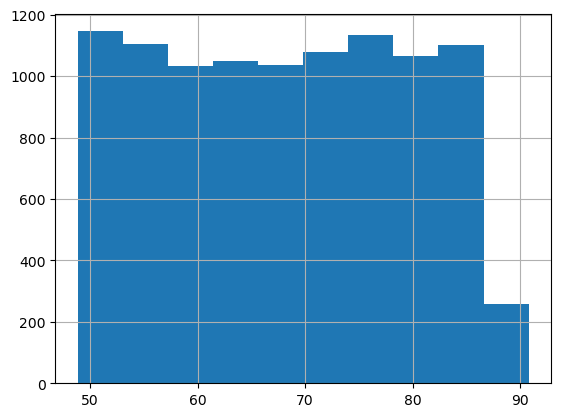

In [44]:
df_training.labels.hist()

In [45]:
train_sampler = create_sampler(df_index, train_ds)

In [46]:
train_loader_equal = DataLoader(train_ds, batch_size=64, sampler=train_sampler)

In [47]:
for _, y in train_loader_equal:
    print(y)
    print(f"mean: {y.mean()}, std: {y.std()}, min:{y.min()}, max:{y.max()}")
    break

tensor([81.5577, 64.8449, 52.8118, 71.9345, 52.1564, 51.6227, 55.2779, 90.7993,
        82.4844, 68.6235, 52.4032, 66.0823, 90.7993, 54.8360, 49.3417, 69.5508,
        69.6030, 82.2364, 69.3279, 81.2541, 75.5329, 79.8437, 48.8372, 84.5662,
        82.8677, 65.2995, 74.4279, 62.4988, 65.3198, 75.4592, 77.5297, 66.0572,
        61.0377, 77.0539, 61.4920, 76.6034, 75.3585, 84.5662, 58.4289, 51.8917,
        57.7966, 52.2250, 80.9042, 50.2267, 82.8677, 64.6246, 56.6235, 59.0369,
        69.8026, 61.7842, 53.1814, 75.6453, 52.2438, 81.3345, 51.0164, 63.4172,
        81.1513, 66.1900, 68.2788, 77.9569, 78.0896, 73.4815, 66.3122, 73.0141])
mean: 68.11600494384766, std: 11.625225067138672, min:48.83718490600586, max:90.79933166503906


In [48]:
df_temp = df_index.iloc[train_ds.indices]
df_temp

,g-0_p-0,g-0_p-1,g-0_p-2,g-0_p-3,g-0_p-4,g-1_p-0,g-1_p-1,g-1_p-2,g-1_p-3,g-1_p-4,...,g-8_p-1,g-8_p-2,g-8_p-3,g-8_p-4,g-9_p-0,g-9_p-1,g-9_p-2,g-9_p-3,g-9_p-4,label
8881,41,74,187,246,180,280,301,298,96,83,...,336,174,80,58,278,228,160,106,126,67.868893
5876,282,363,117,180,372,60,82,26,184,53,...,245,73,242,28,351,370,207,149,151,63.981707
1172,128,54,170,252,27,154,310,38,354,298,...,157,312,30,7,174,145,22,18,322,65.956680
7787,282,130,57,211,256,64,25,243,344,19,...,251,128,62,144,4,199,259,73,153,62.298733
8951,37,32,13,118,136,129,281,256,112,363,...,55,78,62,303,340,188,149,309,298,61.945040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5765,84,209,78,185,259,258,40,217,148,90,...,336,312,62,238,200,47,231,345,69,66.911693
6050,241,53,114,39,16,204,26,297,266,232,...,141,75,21,259,299,216,140,300,88,66.280320
7765,164,104,15,3,11,121,373,6,262,34,...,322,199,75,205,347,358,251,179,371,65.218920
7296,129,264,321,71,218,58,344,252,148,339,...,231,336,295,149,309,89,70,245,350,54.193333


In [49]:
df_temp.iloc[0]

g-0_p-0     41.000000
g-0_p-1     74.000000
g-0_p-2    187.000000
g-0_p-3    246.000000
g-0_p-4    180.000000
g-1_p-0    280.000000
g-1_p-1    301.000000
g-1_p-2    298.000000
g-1_p-3     96.000000
g-1_p-4     83.000000
g-2_p-0      3.000000
g-2_p-1    109.000000
g-2_p-2    164.000000
g-2_p-3    257.000000
g-2_p-4     33.000000
g-3_p-0    253.000000
g-3_p-1    211.000000
g-3_p-2    208.000000
g-3_p-3     54.000000
g-3_p-4    217.000000
g-4_p-0    314.000000
g-4_p-1     84.000000
g-4_p-2      4.000000
g-4_p-3    357.000000
g-4_p-4    266.000000
g-5_p-0     63.000000
g-5_p-1    185.000000
g-5_p-2    213.000000
g-5_p-3    114.000000
g-5_p-4    233.000000
g-6_p-0    130.000000
g-6_p-1    159.000000
g-6_p-2    365.000000
g-6_p-3    241.000000
g-6_p-4    209.000000
g-7_p-0    361.000000
g-7_p-1    226.000000
g-7_p-2     18.000000
g-7_p-3    277.000000
g-7_p-4    311.000000
g-8_p-0     75.000000
g-8_p-1    336.000000
g-8_p-2    174.000000
g-8_p-3     80.000000
g-8_p-4     58.000000
g-9_p-0   

# Generate complete dataset

In [50]:
from itertools import permutations

In [51]:
list(permutations(range(3), 2))

[(0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1)]

In [52]:
num_gondolas = 10
num_part_pg = 5

In [53]:
n_persons = 374

In [54]:
# create all combinations
all_perms = permutations(range(1, n_persons + 1), num_gondolas*num_part_pg)

Wait... way too large! this has over 10^89 possibilities - scrap this

# Generation of testset

In [55]:
# idea: want to generate elements that are valid permutations and are not in the training set
df_index, df_health = generate_ferris_dataset(
    num_gondolas=num_gondolas,
    num_part_pg=num_part_pg,
    num_to_generate=num_to_generate,
    dataset_path="../datasets",
    df_intermediate_output_name="health_dataset_preprocessed-1.csv",
    df_name_input="Sleep_health_and_lifestyle_dataset.csv",
    try_pregen=True
)

In [56]:
df_index

,g-0_p-0,g-0_p-1,g-0_p-2,g-0_p-3,g-0_p-4,g-1_p-0,g-1_p-1,g-1_p-2,g-1_p-3,g-1_p-4,...,g-8_p-1,g-8_p-2,g-8_p-3,g-8_p-4,g-9_p-0,g-9_p-1,g-9_p-2,g-9_p-3,g-9_p-4,label
0,264,191,98,235,35,356,253,9,147,311,...,315,265,92,23,287,17,234,223,117,68.011480
1,338,176,95,11,161,248,364,53,64,71,...,181,365,96,187,165,38,114,98,56,55.463373
2,290,99,75,21,237,287,215,213,172,214,...,76,188,274,77,264,117,254,168,65,66.108493
3,15,277,93,106,290,354,60,226,75,318,...,243,288,74,131,344,86,266,218,83,58.642507
4,190,260,34,286,360,167,251,298,256,15,...,48,258,107,5,307,121,162,7,37,62.584213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,127,84,110,152,265,90,318,72,331,237,...,7,341,126,70,208,67,248,291,246,63.678893
9996,286,97,191,288,32,268,41,347,272,169,...,178,269,310,79,370,108,189,340,24,55.686920
9997,372,168,198,199,239,369,323,277,174,281,...,112,75,331,177,163,155,7,188,290,66.045467
9998,154,310,224,59,87,207,97,78,290,241,...,338,254,183,145,22,95,247,158,231,72.811613


In [57]:
df_test = sample_new_permutations(
    df_index=df_index,
    num_gondolas=num_gondolas,
    num_elem=10,
    merge_check=True
)

100%|██████████| 10/10 [00:00<?, ?it/s]


In [58]:
df_test

,g-0_p-0,g-0_p-1,g-0_p-2,g-0_p-3,g-0_p-4,g-1_p-0,g-1_p-1,g-1_p-2,g-1_p-3,g-1_p-4,...,g-8_p-1,g-8_p-2,g-8_p-3,g-8_p-4,g-9_p-0,g-9_p-1,g-9_p-2,g-9_p-3,g-9_p-4,label
0,4,268,174,238,70,273,27,9,18,243,...,252,373,60,168,41,159,330,346,244,59.592960
1,242,276,303,374,300,28,27,2,324,230,...,245,268,78,117,57,128,191,92,85,70.864360
2,272,1,339,194,129,147,280,85,321,351,...,219,228,340,316,245,289,10,299,106,58.385373
3,283,246,230,158,11,170,162,237,38,101,...,25,145,287,281,191,79,63,27,81,57.203640
4,371,290,60,23,44,208,347,56,177,143,...,120,215,366,368,151,361,333,89,95,56.395627
5,63,230,282,277,4,77,224,244,40,33,...,221,89,116,245,247,82,226,322,170,68.696147
6,63,259,151,221,189,98,85,99,62,139,...,358,168,50,121,298,107,36,158,91,77.823420
7,286,220,245,108,150,306,40,24,368,369,...,212,185,210,328,238,190,359,341,228,69.680560
8,143,358,239,366,149,61,267,255,222,223,...,49,169,199,259,5,92,130,11,98,56.106613
9,86,197,36,240,62,143,238,282,306,348,...,33,253,302,58,203,99,147,225,305,63.063280


In [59]:
df_test2 = df_index.iloc[-10:]
df_test2

,g-0_p-0,g-0_p-1,g-0_p-2,g-0_p-3,g-0_p-4,g-1_p-0,g-1_p-1,g-1_p-2,g-1_p-3,g-1_p-4,...,g-8_p-1,g-8_p-2,g-8_p-3,g-8_p-4,g-9_p-0,g-9_p-1,g-9_p-2,g-9_p-3,g-9_p-4,label
9990,106,45,228,126,234,246,89,105,243,344,...,130,87,167,310,217,146,21,54,317,61.771467
9991,324,53,301,257,20,48,316,73,319,184,...,138,195,237,11,7,291,221,249,272,62.655867
9992,284,346,238,179,80,22,190,123,17,242,...,71,265,347,186,191,37,78,234,320,64.899493
9993,123,261,272,361,15,8,346,89,281,242,...,99,371,32,144,55,178,60,17,319,57.060120
9994,146,13,58,171,90,4,24,31,187,185,...,86,205,244,196,222,29,295,199,137,59.295680
9995,127,84,110,152,265,90,318,72,331,237,...,7,341,126,70,208,67,248,291,246,63.678893
9996,286,97,191,288,32,268,41,347,272,169,...,178,269,310,79,370,108,189,340,24,55.686920
9997,372,168,198,199,239,369,323,277,174,281,...,112,75,331,177,163,155,7,188,290,66.045467
9998,154,310,224,59,87,207,97,78,290,241,...,338,254,183,145,22,95,247,158,231,72.811613
9999,351,31,277,304,357,35,111,254,40,69,...,71,65,163,296,123,363,180,148,297,53.813760


In [60]:
merged = df_test2.merge(df_index, how='left', indicator=True)

In [61]:
merged

,g-0_p-0,g-0_p-1,g-0_p-2,g-0_p-3,g-0_p-4,g-1_p-0,g-1_p-1,g-1_p-2,g-1_p-3,g-1_p-4,...,g-8_p-2,g-8_p-3,g-8_p-4,g-9_p-0,g-9_p-1,g-9_p-2,g-9_p-3,g-9_p-4,label,_merge
0,106,45,228,126,234,246,89,105,243,344,...,87,167,310,217,146,21,54,317,61.771467,both
1,324,53,301,257,20,48,316,73,319,184,...,195,237,11,7,291,221,249,272,62.655867,both
2,284,346,238,179,80,22,190,123,17,242,...,265,347,186,191,37,78,234,320,64.899493,both
3,123,261,272,361,15,8,346,89,281,242,...,371,32,144,55,178,60,17,319,57.060120,both
4,146,13,58,171,90,4,24,31,187,185,...,205,244,196,222,29,295,199,137,59.295680,both
5,127,84,110,152,265,90,318,72,331,237,...,341,126,70,208,67,248,291,246,63.678893,both
6,286,97,191,288,32,268,41,347,272,169,...,269,310,79,370,108,189,340,24,55.686920,both
7,372,168,198,199,239,369,323,277,174,281,...,75,331,177,163,155,7,188,290,66.045467,both
8,154,310,224,59,87,207,97,78,290,241,...,254,183,145,22,95,247,158,231,72.811613,both
9,351,31,277,304,357,35,111,254,40,69,...,65,163,296,123,363,180,148,297,53.813760,both


In [62]:
sum(merged['_merge'] == 'both')

10

In [63]:
merged._merge

0    both
1    both
2    both
3    both
4    both
5    both
6    both
7    both
8    both
9    both
Name: _merge, dtype: category
Categories (3, object): ['left_only', 'right_only', 'both']

## Other labels

In [64]:
from etnn.data.ferris_score_helpers import build_generative_label, build_label_tree
from etnn.data.ferris_wheel import prepare_1_ferris, generate_ferris_dataset
from etnn import TreeNode

In [65]:
num_gondolas = 10
num_part_pg = 5
num_to_generate = 10000

In [66]:
df_health = prepare_1_ferris(
    dataset_path="../datasets",
    df_name_output="health_dataset_preprocessed-1.csv",
    df_name_input="Sleep_health_and_lifestyle_dataset.csv",
    try_pregen=True
)

In [67]:
tree = TreeNode("C", [
    TreeNode("P", [TreeNode("E", num_part_pg)])
    for _ in range(num_gondolas)
])

In [68]:
label = build_generative_label(
    tree=tree,
    df_health=df_health,
    map_element=list(range(1,51))
)
label

array([[1.48979167e+02, 1.12388889e+01, 3.06222222e+01, 2.56166667e+01,
        2.11001389e+02, 2.22083333e+01, 1.05000000e+00, 1.92466667e+02,
        1.64023611e+04, 5.75000000e-01, 2.04888889e+02, 1.08338889e+02,
        8.75000000e-01, 8.33333333e-02, 0.00000000e+00]])

In [69]:
label = build_label_tree(
    df_health=df_health,
    map_element=list(range(1,51)),
    num_gondolas=num_gondolas,
    num_part_pg=num_part_pg,
    final_label_factor=1/1000
)
label

17.360305555555556

In [70]:
df_index, df_health = generate_ferris_dataset(
    num_gondolas=num_gondolas,
    num_part_pg=num_part_pg,
    num_to_generate=num_to_generate,
    dataset_path="../datasets",
    df_intermediate_output_name="health_dataset_preprocessed-1.csv",
    df_name_input="Sleep_health_and_lifestyle_dataset.csv",
    try_pregen=True,
    label_type="tree",
    final_label_factor=1/1000
)

In [71]:
df_index

,g-0_p-0,g-0_p-1,g-0_p-2,g-0_p-3,g-0_p-4,g-1_p-0,g-1_p-1,g-1_p-2,g-1_p-3,g-1_p-4,...,g-8_p-1,g-8_p-2,g-8_p-3,g-8_p-4,g-9_p-0,g-9_p-1,g-9_p-2,g-9_p-3,g-9_p-4,label
0,264,191,98,235,35,356,253,9,147,311,...,315,265,92,23,287,17,234,223,117,16.653669
1,338,176,95,11,161,248,364,53,64,71,...,181,365,96,187,165,38,114,98,56,16.600923
2,290,99,75,21,237,287,215,213,172,214,...,76,188,274,77,264,117,254,168,65,17.770394
3,15,277,93,106,290,354,60,226,75,318,...,243,288,74,131,344,86,266,218,83,16.351700
4,190,260,34,286,360,167,251,298,256,15,...,48,258,107,5,307,121,162,7,37,16.668119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,127,84,110,152,265,90,318,72,331,237,...,7,341,126,70,208,67,248,291,246,15.740224
9996,286,97,191,288,32,268,41,347,272,169,...,178,269,310,79,370,108,189,340,24,17.720740
9997,372,168,198,199,239,369,323,277,174,281,...,112,75,331,177,163,155,7,188,290,16.765433
9998,154,310,224,59,87,207,97,78,290,241,...,338,254,183,145,22,95,247,158,231,16.789893


<Axes: >

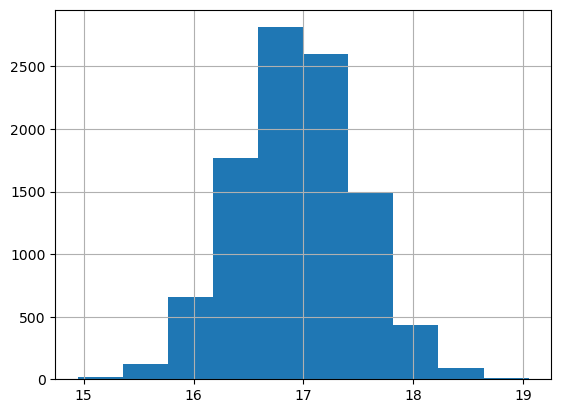

In [72]:
df_index.label.hist()

In [73]:
dataset, _ = load_pure_ferris_wheel_dataset(
    num_gondolas=num_gondolas,
    num_part_pg=num_part_pg,
    num_to_generate=num_to_generate,
    dataset_path="../datasets",
    df_intermediate_output_name="health_dataset_preprocessed-1.csv",
    df_name_input="Sleep_health_and_lifestyle_dataset.csv",
    try_pregen=True,
    label_type = "tree",
    final_label_factor = 1/1000
)
dataset[0]

(tensor([[4.5000e+01, 1.1000e+01, 6.9000e+00, 7.0000e+00, 5.5000e+01, 5.0000e+00,
          2.0000e+00, 7.5000e+01, 5.5000e+03, 0.0000e+00, 1.2500e+02, 8.2000e+01,
          0.0000e+00, 1.0000e+00, 0.0000e+00],
         [4.3000e+01, 4.0000e+00, 6.7000e+00, 7.0000e+00, 4.5000e+01, 4.0000e+00,
          2.0000e+00, 6.5000e+01, 6.0000e+03, 2.0000e+00, 1.3500e+02, 9.0000e+01,
          0.0000e+00, 1.0000e+00, 0.0000e+00],
         [3.6000e+01, 7.0000e+00, 7.1000e+00, 8.0000e+00, 6.0000e+01, 4.0000e+00,
          0.0000e+00, 6.8000e+01, 7.0000e+03, 0.0000e+00, 1.1500e+02, 7.5000e+01,
          0.0000e+00, 1.0000e+00, 0.0000e+00],
         [4.4000e+01, 4.0000e+00, 6.6000e+00, 7.0000e+00, 4.5000e+01, 4.0000e+00,
          2.0000e+00, 6.5000e+01, 6.0000e+03, 2.0000e+00, 1.3500e+02, 9.0000e+01,
          0.0000e+00, 1.0000e+00, 0.0000e+00],
         [3.1000e+01, 2.0000e+00, 7.7000e+00, 7.0000e+00, 7.5000e+01, 6.0000e+00,
          0.0000e+00, 7.0000e+01, 8.0000e+03, 0.0000e+00, 1.2000e+02, 8.00

In [74]:
dataset, _ = load_modified_ferris_wheel_dataset(
    num_gondolas=num_gondolas,
    num_part_pg=num_part_pg,
    num_to_generate=num_to_generate,
    num_valid_to_add=num_to_generate,
    dataset_path="../datasets",
    df_intermediate_output_name="health_dataset_preprocessed-1.csv",
    df_name_input="Sleep_health_and_lifestyle_dataset.csv",
    try_pregen=True,
    label_type = "tree",
    final_label_factor = 1/1000
)

100%|██████████| 1000/1000 [00:00<00:00, 99931.00it/s]


In [75]:
dataset[0]

(tensor([[4.5000e+01, 1.1000e+01, 6.9000e+00, 7.0000e+00, 5.5000e+01, 5.0000e+00,
          2.0000e+00, 7.5000e+01, 5.5000e+03, 0.0000e+00, 1.2500e+02, 8.2000e+01,
          0.0000e+00, 1.0000e+00, 0.0000e+00],
         [4.3000e+01, 4.0000e+00, 6.7000e+00, 7.0000e+00, 4.5000e+01, 4.0000e+00,
          2.0000e+00, 6.5000e+01, 6.0000e+03, 2.0000e+00, 1.3500e+02, 9.0000e+01,
          0.0000e+00, 1.0000e+00, 0.0000e+00],
         [3.6000e+01, 7.0000e+00, 7.1000e+00, 8.0000e+00, 6.0000e+01, 4.0000e+00,
          0.0000e+00, 6.8000e+01, 7.0000e+03, 0.0000e+00, 1.1500e+02, 7.5000e+01,
          0.0000e+00, 1.0000e+00, 0.0000e+00],
         [4.4000e+01, 4.0000e+00, 6.6000e+00, 7.0000e+00, 4.5000e+01, 4.0000e+00,
          2.0000e+00, 6.5000e+01, 6.0000e+03, 2.0000e+00, 1.3500e+02, 9.0000e+01,
          0.0000e+00, 1.0000e+00, 0.0000e+00],
         [3.1000e+01, 2.0000e+00, 7.7000e+00, 7.0000e+00, 7.5000e+01, 6.0000e+00,
          0.0000e+00, 7.0000e+01, 8.0000e+03, 0.0000e+00, 1.2000e+02, 8.00